# weather api agent

this agent has a couple tools to call the weather.gov API


## install dependencies

In [1]:
# %pip install --quiet -U langchain_openai langchain_core langgraph langchain-pinecone pinecone-notebooks

## set the OpenAI API Key

In [2]:
import os, getpass

def _set_env(var: str):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"Enter your {var}: ")

_set_env("OPENAI_API_KEY")

## define the LLM model

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

## build the weather tool

In [4]:
from main import get_one_day_forecast, get_week_forecast

def get_weather_current():
    """
        Use this to get the current weather.
    """
                
    return get_one_day_forecast()

def get_weather_week():
    """
    Use this to get the weather forecast for the next week.
    """
    
    # Assuming get_week_forecast() is defined in main.py similar to get_one_day_forecast()
    return get_week_forecast()

weather_tool = [get_weather_current, get_weather_week]

## bind the tool

In [5]:
llm_with_weather_tool = llm.bind_tools(weather_tool)

## build the LLM node

In [6]:
from langgraph.graph import MessagesState
from langchain_core.messages import trim_messages

def llm_with_tools_node(state: MessagesState):

  # trim the messages to the last 150 tokens worth
  messages = trim_messages(
      messages=state["messages"],
      strategy="last",
      token_counter=ChatOpenAI(model="gpt-4o-mini"),
      max_tokens=1000,
      start_on="human",
      allow_partial=False,
  )

  return {"messages": [llm_with_weather_tool.invoke(messages)]}

## build the graph

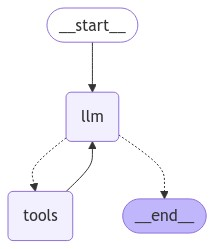

In [7]:
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image

builder = StateGraph(MessagesState)

# add nodes
builder.add_node("llm", llm_with_tools_node)
builder.add_node("tools", ToolNode(weather_tool))

# connect them (add edges)
builder.add_edge(START, "llm")
builder.add_conditional_edges("llm", tools_condition)
builder.add_edge("tools", "llm")

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## invoke the graph


In [11]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="best time to windsurf this week?")]
# messages = graph.invoke(input={"messages": messages})
messages = graph.invoke(input={"messages": messages}) 

for m in messages['messages']:
    m.pretty_print()

https://api.weather.gov/gridpoints/PQR/152,105/forecast
================================ Human Message =================================

best time to windsurf this week?
================================== Ai Message ==================================
Tool Calls:
  get_weather_week (call_aoKG6nF2GuquetBcLI4Ez33R)
 Call ID: call_aoKG6nF2GuquetBcLI4Ez33R
  Args:
================================= Tool Message =================================
Name: get_weather_week

[{"date": "Tonight", "forecast": "Partly cloudy. Low around 47, with temperatures rising to around 49 overnight. West wind around 3 mph."}, {"date": "Sunday", "forecast": "Rain after 2pm. Partly sunny. High near 71, with temperatures falling to around 68 in the afternoon. Southwest wind 2 to 9 mph. Chance of precipitation is 100%. New rainfall amounts less than a tenth of an inch possible."}, {"date": "Sunday Night", "forecast": "Rain. Cloudy. Low around 48, with temperatures rising to around 51 overnight. West wind 6 to 9 mph